<a href="https://colab.research.google.com/github/andrecoimbra/CTG_RP_PC_2025/blob/main/CTG_Generate_Poincare_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CTG Generate Poincaré Plots

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! wget https://raw.githubusercontent.com/andrecoimbra/CTG_RP_PC_2025/main/src/config_local.py

--2025-02-08 19:08:00--  https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/config_local.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1358 (1.3K) [text/plain]
Saving to: ‘config_local.py’

config_local.py     100%[===================>]   1.33K  --.-KB/s    in 0s      

2025-02-08 19:08:01 (44.6 MB/s) - ‘config_local.py’ saved [1358/1358]



In [ ]:
from config_local import *
get_github_files(['ctg_utils.py', 'basic_denoise.py', 'libPC.py' ])    # for development purposes only

Beginning file download of file ctg_utils.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/ctg_utils.py
Beginning file download of file basic_denoise.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/basic_denoise.py
Beginning file download of file libPC.py
https://raw.githubusercontent.com/andre-coimbra-ifg/CTG_RP_PC/master/src/libPC.py
Done


In [ ]:
#! rm -R  /content/images
! ls  /content

basic_denoise.py  config_local.py  ctg_utils.py  libPC.py  __pycache__	sample_data


In [ ]:
! pip install wfdb
! pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.0 MB/s eta 0:00:00


In [ ]:
!gdown 1h_qlULLpSR9fAJvzeE1Zkq2C2aIuB-N9
!unzip "/content/ctu-uhb-ctgdb.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1h_qlULLpSR9fAJvzeE1Zkq2C2aIuB-N9
To: /content/ctu-uhb-ctgdb.zip
100% 14.4M/14.4M [00:00<00:00, 48.6MB/s]
Archive:  /content/ctu-uhb-ctgdb.zip
   creating: /content/ctu-uhb-ctgdb/
  inflating: /content/ctu-uhb-ctgdb/1220.dat  
  inflating: /content/ctu-uhb-ctgdb/1234.dat  
  inflating: /content/ctu-uhb-ctgdb/1208.dat  
  inflating: /content/ctu-uhb-ctgdb/1038.hea  
  inflating: /content/ctu-uhb-ctgdb/1004.hea  
  inflating: /content/ctu-uhb-ctgdb/1010.hea  
  inflating: /content/ctu-uhb-ctgdb/1022.dat  
  inflating: /content/ctu-uhb-ctgdb/1036.dat  
  inflating: /content/ctu-uhb-ctgdb/2041.hea  
  inflating: /content/ctu-uhb-ctgdb/1206.hea  
  inflating: /content/ctu-uhb-ctgdb/1212.hea  
  inflating: /content/ctu-uhb-ctgdb/1156.dat  
  inflating: /content/ctu-uhb-ctgdb/1142.dat  
  inflating: /content/ctu-uhb-ctgdb/1399.hea  
  inflating: /content/ctu-uhb-ctgdb/1428.hea  
  inflating: /content/ctu-uhb-ctgdb/1195.dat  
  inflating: /co

In [ ]:
! rm -R images

rm: cannot remove 'images': No such file or directory


In [ ]:
import os
import json
from pprint import pprint

import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt

import wfdb
from ctg_utils import get_all_recno, parse_meta_comments
import basic_denoise
from basic_denoise import get_valid_segments, get_segment_concatenation, get_segment_removing_zeros

from libPC import create_pc

In [ ]:
# !wget -r -N -c -np -q --show-progress -P /content/ctu-uhb-ctgdb https://physionet.org/files/ctu-uhb-ctgdb/1.0.0/

In [ ]:
# !mv /content/ctu-uhb-ctgdb/physionet.org/files/ctu-uhb-ctgdb/1.0.0/* /content/ctu-uhb-ctgdb
# !rm -r /content/ctu-uhb-ctgdb/physionet.org

# Config

In [ ]:
POLICY='late_valid' # 'best_quality', 'early_valid', 'late_valid'

# Code

In [ ]:
POLICIES = ['best_quality', 'early_valid', 'late_valid']

def generate_pc_images(recordings_dir, n_dec=4, clip_stage_II=False,
                       max_seg_min=10, policy='early_valid',
                       images_dir='', images_index_file='pc_images_index.json',
                       show_signal=False, show_image=False, verbose=False, cmap=None,
                       limit=-1):

    assert policy in POLICIES

    if images_dir and not os.path.exists(images_dir):
        os.mkdir(images_dir)

    max_seg = int(max_seg_min*60*4)  # convert to samples

    results = {}
    for recno in sorted(get_all_recno(recordings_dir)):
        if limit == 0:
            break
        limit -= 1

        recno_full = os.path.join(recordings_dir, recno)
        all_sig, meta = wfdb.io.rdsamp(recno_full)
        meta = parse_meta_comments(meta['comments'])
        if verbose:
            print('\nRecord: {}  Samples: {}   Duration: {:0.1f} min   Stage.II: {} min'.format(
                recno, all_sig.shape[0], all_sig.shape[0]/4/60, meta['Delivery']['II.stage']))

        sig_hr = all_sig[:, 0]
        if clip_stage_II and meta['Delivery']['II.stage'] != -1:
            idx = int(meta['Delivery']['II.stage']*60*4)
            sig_hr = sig_hr[:-idx]
        ts = np.arange(len(sig_hr))/4.0

        if show_signal:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Signal'.format(recno))
            plt.plot(ts/60, sig_hr)
            plt.xlim(ts[0], ts[-1]/60)
            plt.ylim(50, 200)
            plt.show()

        # select segment with lowest error rate
        selected_segments = get_valid_segments(
            sig_hr, ts, recno, verbose=False)

        if len(selected_segments) == 0:
            continue

        if policy == 'best_quality':
            selected_segments = sorted(
                selected_segments, key=lambda x: -x['pct_valid'])
        elif policy == 'early_valid':
            selected_segments = sorted(
                selected_segments, key=lambda x: x['seg_start'])
        elif policy == 'late_valid':
            selected_segments = sorted(
                selected_segments, key=lambda x: -x['seg_end'])

        seg = selected_segments[0]
        seg_start = seg['seg_start']
        seg_end = seg['seg_end']
        seg_hr = seg['seg_hr']
        seg_tm = seg['seg_ts'] / 60
        orig_seg_hr = seg['orig_seg_hr']
        mask = seg['mask']
        pct_valid = seg['pct_valid']

        if show_signal:
            plt.figure(figsize=(12, 2))
            plt.title('{}: Segment  {}-{}'.format(recno, seg_start, seg_end))
            plt.plot(seg_tm, seg_hr)
            plt.plot(seg_tm, orig_seg_hr, alpha=0.25)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(50, 200)
            plt.show()

            plt.figure(figsize=(12, 2))
            plt.title('{}: Invalid'.format(recno))
            plt.plot(seg_tm, ~mask)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(-0.1, 1.1)
            plt.show()

            print('Valid: {:0.1f}%'.format(100 * pct_valid))

        if policy == 'late_valid':
            selected_hr = seg_hr[-max_seg:]
        else:
            selected_hr = seg_hr[:max_seg]

        if n_dec > 1:
            selected_hr = scipy.signal.decimate(selected_hr, n_dec)

        # TODO: mudar para único arquivo, alterar no arquivo compute_metadata -> annotate_train_valid_group
        image_names = []
        fname = create_pc(selected_hr, base_name=recno, show_image=show_image,
                          images_dir=images_dir, cmap=cmap, use_clip=clip_stage_II)
        image_names.append(fname)

        results[recno] = {'names': image_names, 'outcome': meta['Outcome']}

    if verbose:
        pprint(results)

    with open(os.path.join(images_dir, images_index_file), 'w') as outfile:
        json.dump(results, outfile)


def generate_pc_images_segment(recordings_dir, n_dec=4, clip_stage_II=False,
                               max_seg_min=10, policy='early_valid',
                               images_dir='', images_index_file='pc_images_index.json',
                               show_signal=False, show_image=False, verbose=False, cmap=None,
                               limit=-1):

    assert policy in POLICIES

    if images_dir and not os.path.exists(images_dir):
        os.mkdir(images_dir)

    results = {}
    for recno in sorted(get_all_recno(recordings_dir)):
        if limit == 0:
            break
        limit -= 1

        # if recno != '1005':
        #     # print(recno)
        #     continue

        recno_full = os.path.join(recordings_dir, recno)
        all_sig, meta = wfdb.io.rdsamp(recno_full)
        meta = parse_meta_comments(meta['comments'])
        if verbose:
            print('\nRecord: {}  Samples: {}   Duration: {:0.1f} min   Stage.II: {} min'.format(
                recno, all_sig.shape[0], all_sig.shape[0]/4/60, meta['Delivery']['II.stage']))

        sig_hr = all_sig[:, 0]
        if clip_stage_II and meta['Delivery']['II.stage'] != -1:
            idx = int(meta['Delivery']['II.stage']*60*4)
            sig_hr = sig_hr[:-idx]
        ts = np.arange(len(sig_hr))/4.0

        # select concatenation of segments as close to the chosen length
        segment = get_segment_concatenation(
            sig_hr, ts, recno, max_seg_min=max_seg_min, policy=policy)

        if len(segment) == 0:
            continue

        if show_signal:
            seg_start = segment['seg_start']
            seg_end = segment['seg_end']
            seg_hr = segment['seg_hr']
            seg_tm = segment['seg_ts'] / 60
            orig_seg_hr = segment['orig_seg_hr']

            seg_tm = np.arange(len(seg_hr))/4.0/60

            plt.figure(figsize=(12, 3.8))
            plt.title('{}: Final Segment  {}-{} (considered length = {:0.1f} min)'
                      .format(recno, seg_start, seg_end, len(seg_hr)/60/4))
            plt.plot(seg_tm, seg_hr)
            plt.plot(seg_tm, orig_seg_hr, alpha=0.25)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(50, 200)
            plt.xlabel("Time [seconds]")
            plt.ylabel("FHR [bpm]")
            plt.show()

            print('Segment length: {:0.1f} min'.format(len(seg_hr)/60/4))

        selected_hr = segment['seg_hr']

        # Reduce signal sampling rate (compact)
        if n_dec > 1:
            selected_hr = scipy.signal.decimate(selected_hr, n_dec)

        selected_hr = np.round(selected_hr).astype(int)

        # Keep list to maintain structure used in other methods
        image_names = []
        fname = create_pc(selected_hr, base_name=recno, show_image=show_image,
                          images_dir=images_dir, cmap=cmap, use_clip=clip_stage_II)
        image_names.append(fname)

        results[recno] = {'names': image_names, 'outcome': meta['Outcome']}

    if verbose:
        pprint(results)

    with open(os.path.join(images_dir, images_index_file), 'w') as outfile:
        json.dump(results, outfile)

    return len(results)


def generate_pc_images_simple(recordings_dir, n_dec=4, clip_stage_II=False,
                              max_seg_min=10, policy='early_valid',
                              rp_params=[{}], images_dir='',
                              images_index_file='rp_images_index.json',
                              show_signal=False, show_image=False, verbose=False, cmap=None,
                              limit=-1):

    assert policy in POLICIES

    if images_dir and not os.path.exists(images_dir):
        os.mkdir(images_dir)

    results = {}
    for recno in sorted(get_all_recno(recordings_dir)):
        if limit == 0:
            break
        limit -= 1

        # if recno != '1005':
        #     # print(recno)
        #     continue

        recno_full = os.path.join(recordings_dir, recno)
        all_sig, meta = wfdb.io.rdsamp(recno_full)
        meta = parse_meta_comments(meta['comments'])
        if verbose:
            print('\nRecord: {}  Samples: {}   Duration: {:0.1f} min   Stage.II: {} min'.format(
                recno, all_sig.shape[0], all_sig.shape[0]/4/60, meta['Delivery']['II.stage']))

        sig_hr = all_sig[:, 0]
        if clip_stage_II and meta['Delivery']['II.stage'] != -1:
            idx = int(meta['Delivery']['II.stage']*60*4)
            sig_hr = sig_hr[:-idx]
        ts = np.arange(len(sig_hr))/4.0

        # select concatenation of segments as close to the chosen length
        segment = get_segment_removing_zeros(
            sig_hr, ts, recno, max_seg_min=max_seg_min, policy=policy)

        if len(segment) == 0:
            continue

        selected_hr = segment['seg_hr']

        if show_signal:
            seg_tm = np.arange(len(selected_hr))/4.0/60

            plt.figure(figsize=(12, 3.8))
            plt.title('{}: Final Segment (considered length = {:0.1f} min)'
                      .format(recno, len(selected_hr)/60/4))
            plt.plot(seg_tm, selected_hr)
            plt.xlim(seg_tm[0], seg_tm[-1])
            plt.ylim(50, 200)
            plt.xlabel("Time [seconds]")
            plt.ylabel("FHR [bpm]")
            plt.show()

        # Reduce signal sampling rate (compact)
        if n_dec > 1:
            selected_hr = scipy.signal.decimate(selected_hr, n_dec)

        selected_hr = np.round(selected_hr).astype(int)

        # TODO: mudar para único arquivo, alterar no arquivo compute_metadata -> annotate_train_valid_group
        image_names = []
        fname = create_pc(selected_hr, base_name=recno, show_image=show_image,
                          images_dir=images_dir, cmap=cmap, use_clip=clip_stage_II)
        image_names.append(fname)

        results[recno] = {'names': image_names, 'outcome': meta['Outcome']}

#     if verbose:
#         pprint(results)

    with open(os.path.join(images_dir, images_index_file), 'w') as outfile:
        json.dump(results, outfile)

## Process Recordings

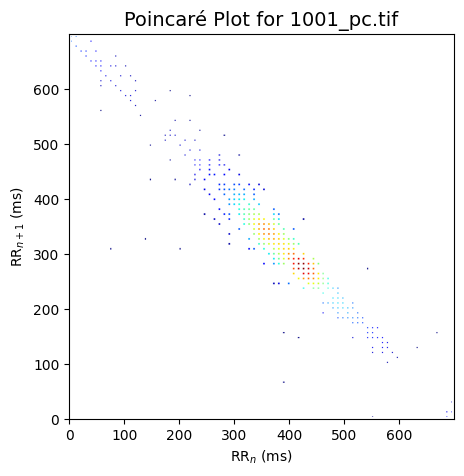

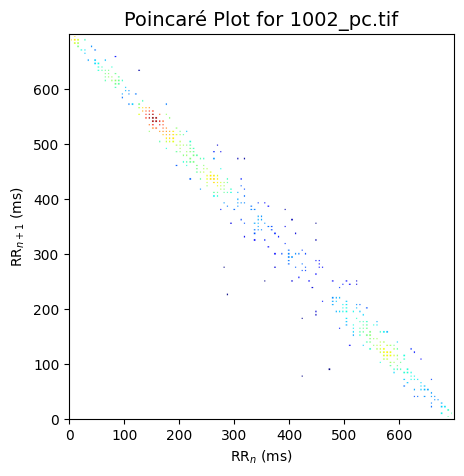

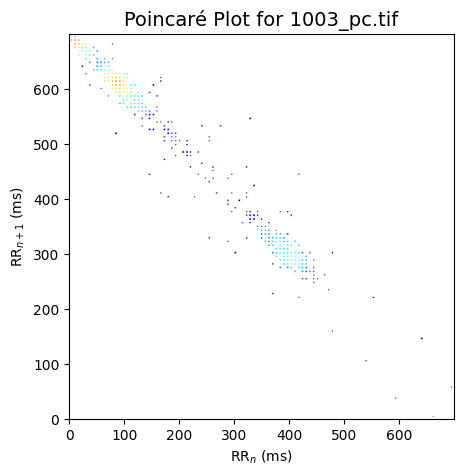

3

In [ ]:
CMAP = 'jet' # 'jet', 'binary', 'gray'

generate_pc_images_segment(RECORDINGS_DIR, images_dir=IMAGES_DIR, policy=POLICY,
                           show_signal=False, show_image=True, verbose=False,
                           cmap=CMAP, limit=3, max_seg_min=10, n_dec=4)

In [ ]:
generate_pc_images_segment(RECORDINGS_DIR, images_dir=IMAGES_DIR,
                           policy=POLICY, show_signal=False, show_image=False,
                           verbose=True, cmap=CMAP, max_seg_min=10, n_dec=4)


Record: 1001  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1002  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1003  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1004  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1005  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1006  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1007  Samples: 15600   Duration: 65.0 min   Stage.II: 5 min

Record: 1008  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1009  Samples: 20400   Duration: 85.0 min   Stage.II: 25 min

Record: 1010  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1011  Samples: 15600   Duration: 65.0 min   Stage.II: 5 min

Record: 1012  Samples: 16800   Duration: 70.0 min   Stage.II: 10 min

Record: 1013  Samples: 18000   Duration: 75.0 min   Stage.II: 15 min

Record: 1014  Samples: 19200   Duration: 80.0 min   Stage.II: 20 min

Record: 1015  Samples

552

In [ ]:
IMAGES_DIR

'/content/images'

In [ ]:
ls /content/images/1171*

/content/images/1171_pc.tif


In [ ]:
with open(os.path.join(IMAGES_DIR, 'pc_images_index.json'), 'r') as infile:
    data = json.load(infile)

print('Recordings:', len(data.keys()))
print('Sample Recording :', data['1001'])

tally = 0
for k in data.keys():
  for i in data[k]['names']:
      tally += 1
print('Total Images', tally)

Recordings: 552
Sample Recording : {'names': ['1001_pc.tif'], 'outcome': {'pH': 7.14, 'BDecf': 8.14, 'pCO2': 7.7, 'BE': -10.5, 'Apgar1': 6, 'Apgar5': 8}}
Total Images 552


In [ ]:
! cat /content/images/pc_images_index.json

{"1001": {"names": ["1001_pc.tif"], "outcome": {"pH": 7.14, "BDecf": 8.14, "pCO2": 7.7, "BE": -10.5, "Apgar1": 6, "Apgar5": 8}}, "1002": {"names": ["1002_pc.tif"], "outcome": {"pH": 7, "BDecf": 7.92, "pCO2": 12, "BE": -12, "Apgar1": 8, "Apgar5": 8}}, "1003": {"names": ["1003_pc.tif"], "outcome": {"pH": 7.2, "BDecf": 3.03, "pCO2": 8.3, "BE": -5.6, "Apgar1": 7, "Apgar5": 9}}, "1004": {"names": ["1004_pc.tif"], "outcome": {"pH": 7.3, "BDecf": 5.19, "pCO2": 5.5, "BE": -6.4, "Apgar1": 8, "Apgar5": 9}}, "1005": {"names": ["1005_pc.tif"], "outcome": {"pH": 7.3, "BDecf": 4.52, "pCO2": 5.7, "BE": -5.8, "Apgar1": 9, "Apgar5": 10}}, "1006": {"names": ["1006_pc.tif"], "outcome": {"pH": 7.23, "BDecf": 1.29, "pCO2": 8.2, "BE": -3.8, "Apgar1": 8, "Apgar5": 9}}, "1007": {"names": ["1007_pc.tif"], "outcome": {"pH": 7.16, "BDecf": 4.35, "pCO2": 8.8, "BE": -6.8, "Apgar1": 9, "Apgar5": 10}}, "1008": {"names": ["1008_pc.tif"], "outcome": {"pH": 7.36, "BDecf": 3.88, "pCO2": 4.9, "BE": -4.6, "Apgar1": 8, "Ap